### 이상치 데이터 처리
- 피쳐/특성에 데이터 값의 범위를 벗어나는 데이터를 의미
- 종류 : 잘못 입력된 경우, 자연으로 생성된 데이터
    * 잘못 입력된 데이터 : ex) 입력시 오타   ===> 제거 또는 대체
    * 자연 생성 데이터 : ex) 연봉, 키, 몸무게, 나이   ===> 분리해서 전용 모델 / 식별용 피쳐
- 탐지
    * 시각화로 확인
    * 데이터의 분포를 확인 : Z-Score / IQR(Turkey Fences)
- 처리
    * 삭제 / 대체 / 분리 모델 / 파생변수 추가 ... => 데이터마다 처리하기 나름이다.

In [155]:
from IPython.display import Image #주피터 노트북에 이미지 삽입

(1) 모듈 로딩 및 데이터 준비 <hr>

In [156]:
import pandas as pd
import matplotlib.pyplot as plt

In [157]:
# 임의의 데이터
dataDF = pd.DataFrame({'num': [ 1,4,3,2,4,5,-14,2,1,15]})
dataDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   num     10 non-null     int64
dtypes: int64(1)
memory usage: 208.0 bytes


In [158]:
dataDF

,num
0,1
1,4
2,3
3,2
4,4
5,5
6,-14
7,2
8,1
9,15


(2) 데이터 전처리 <hr>

(2-1) 데이터 확인

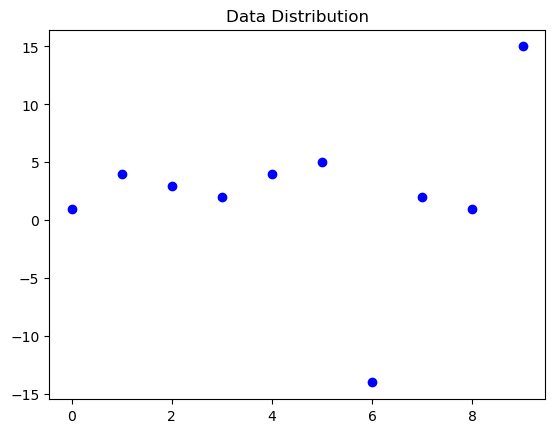

In [159]:
# 시각화로 데이터 분포 확인
plt.plot(dataDF, 'bo')
plt.title('Data Distribution')
plt.show()

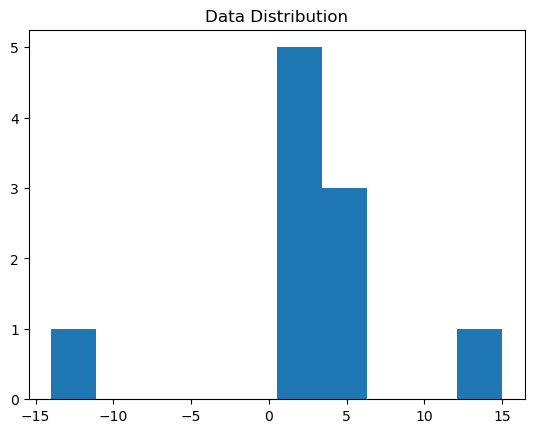

In [160]:
plt.hist(dataDF)
plt.title('Data Distribution')
plt.show()

(2-2) 불필요 데이터 체크 => 결측치, 이상치

In [161]:
# 결측치
dataDF.isnull().sum()

num    0
dtype: int64

In [162]:
# 이상치 탐지 - 방법(1) 평균과 편차를 이용한 탐지 Z - Score
# Z - Score = (데이터 - 평균)/표준편차
mean_value = dataDF['num'].mean()
std_value = dataDF['num'].std()

z_data = (dataDF - mean_value) / std_value
z_data

# 정규분포를 그렸을때 양 끝단의 값을 이상치로 판단하겠다는 story

,num
0,-0.185065
1,0.242008
2,0.099650
3,-0.042707
4,0.242008
5,0.384366
6,-2.320430
7,-0.042707
8,-0.185065
9,1.807942


In [163]:
# 양 끝단 제거를 위한 기준값  => 1.0 으로 정했다
base = 1.0
mask = z_data.abs() > base

In [164]:
z_data[~mask]
# 이상치를 제거하고 나와야하니까 물결을 붙여준다 (반대로 ㅇㅇ)

,num
0,-0.185065
1,0.242008
2,0.099650
3,-0.042707
4,0.242008
5,0.384366
6,NaN
7,-0.042707
8,-0.185065
9,NaN


In [165]:
dataDF[~mask].dropna()
# 결측치가 제거됨
# 만약 결측치를 제거하지 않고 대체하고싶으면 대체해도 된다.

,num
0,1.0
1,4.0
2,3.0
3,2.0
4,4.0
5,5.0
7,2.0
8,1.0


In [166]:
# 이상치 탐지 - 방법(2) 데이터를 4등분해서 가운데 데이터를 기준으로 이상치 탐지
# | ======== | ======== | ======== | ======== | 
#            25%        50%        75%             => 이렇게 4등분하겠다는 소리

q1 = dataDF.quantile(0.25)
q3 = dataDF.quantile(0.75)
iqr = q3 - q1

# 이상치로 판단할 기준되는 값
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

print(f"q1 : {q1} \n q3 : {q3} \n iqr : {iqr}")
print(f"lower : {lower} \n upper : {upper}")

q1 : num    1.25
Name: 0.25, dtype: float64 
 q3 : num    4.0
Name: 0.75, dtype: float64 
 iqr : num    2.75
dtype: float64
lower : num   -2.875
dtype: float64 
 upper : num    8.125
dtype: float64


In [167]:
dataDF < lower , dataDF > upper

# 방법1과 마찬가지로 mask 씌워서 제거 해주면 된다

(     num
 0  False
 1  False
 2  False
 3  False
 4  False
 5  False
 6   True
 7  False
 8  False
 9  False,
      num
 0  False
 1  False
 2  False
 3  False
 4  False
 5  False
 6  False
 7  False
 8  False
 9   True)

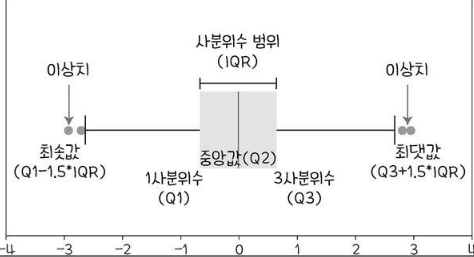

In [168]:
"""
     Q1-1.5IQR   Q1   median  Q3   Q3+1.5IQR
                  |-----:-----|
  o      |--------|     :     |--------|    o  o
                  |-----:-----|
flier             <----------->            fliers
                       IQR


Q1 - 1.5IQR 과 Q1 + 1.5IQR을 넘어서는 값들을 이상치로 보겠다.
"""

Image('img01.png')

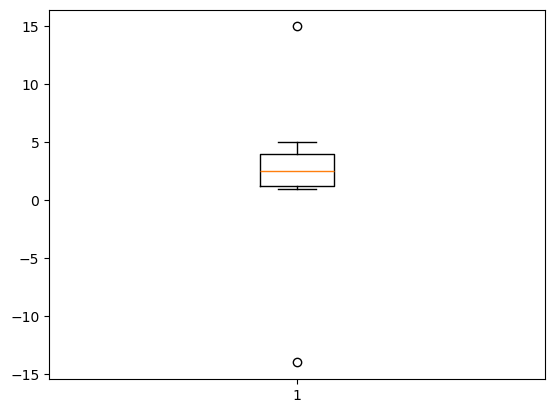

In [169]:
# 시각화
bp_obj = plt.boxplot(dataDF)
plt.show()

In [170]:
# 박스플랏을 그리면 반환값으로 딕셔너리 형태의 값들이 나온다.
bp_obj.keys()

dict_keys(['whiskers', 'caps', 'boxes', 'medians', 'fliers', 'means'])

In [171]:
# q1, min, q3, max
bp_obj['whiskers'][0].get_ydata(), bp_obj['whiskers'][1].get_ydata()

# return값으로,,
# [ 1사분위, 최소값 ]이 나왔고, [ 3사분위, 최대값 ]이 나왔다.

(array([1.25, 1.  ]), array([4., 5.]))

In [172]:
bp_obj['medians'][0].get_ydata()

array([2.5, 2.5])

In [173]:
bp_obj['fliers'][0].get_ydata()

array([-14,  15], dtype=int64)

In [174]:
# 여기서는 버릴 값으로 이상치를 이미 조정해놓은 데이터다.
# 하지만 실제 데이터에서는 이상치라고 다 버리면 안된다. 실제 데이터를 확인해보고 버릴지 말지 , 대체할지, 등등 여러 모델을 만들어서 비교해봐야함.

In [175]:
# 처음에 데이터 확인할 때 결측치, 고유값, 그래프, 이상치 등을 다 확인하는 함수를 하나 만들어놔라. 
# 컬럼명만 바뀌면 그거를 확인할 수 있게끔,, 매번 같은 코드를 짜기엔 쩜^^;;
# 그래서 확인되는 이상치를 어케 할지 판단해보라

In [176]:
"""
(+) [ Q & A ]
- 상관계수를 확인했을때 다 고만고만하다 => 피쳐를 다 가져가야함
- 예쁜 데이터만 할 수없다. 이런 저런 데이터로 일단 해봐야한다. 배경 지식이 없다면 구글링도 해보고,, 그런거지 모,,~ (막막함은 기본이지만 ~ )
- 젤 베스트는 과제할때는 수업시간에 했던 코드 창을 닫고 그냥 쭈우우욱 칠 수 있으면 좋겟다.
  일단 1단계 는 이거햇고 2단계로는 이거해야하고 이런식으로 어째저째 혼자 이끌어 나가봤으면 좋겠다.
- 첨에는 점수를 높인다기 보다는, 사용할 알고리즘이 전제조건이 일치하는가 생각해서 어째저쨰 또 해보고,,, ~
"""

'\n(+) [ Q & A ]\n- 상관계수를 확인했을때 다 고만고만하다 => 피쳐를 다 가져가야함\n- 예쁜 데이터만 할 수없다. 이런 저런 데이터로 일단 해봐야한다. 배경 지식이 없다면 구글링도 해보고,, 그런거지 모,,~ (막막함은 기본이지만 ~ )\n- 젤 베스트는 과제할때는 수업시간에 했던 코드 창을 닫고 그냥 쭈우우욱 칠 수 있으면 좋겟다.\n  일단 1단계 는 이거햇고 2단계로는 이거해야하고 이런식으로 어째저째 혼자 이끌어 나가봤으면 좋겠다.\n'